# Notebook outline
1. Import Libraries
2. Setting up Google Colab (Reviewer can ignore this)
3. Exploring the dataset
4. Preprocessing
5. Data Visualization after Preprocessing
6. Generating Bag of Words and TF-IDF features for Baseline models
7. Training the Baseline Models (Naive Bayes and Logictic Regression) - achieved upto 74% accuracy
8. Improvement over the baseline model: BiLSTM model with pre-trained GloVe word embeddings

   8.1 Network selection using Keras Hyperparameter training

   8.2 Training the Best Model (upto ~88% accuracy)

   8.3 Visualizing training History and testing the model

9. Evaluation
10. End Remarks 

# 1. Import Libraries

In [ ]:
!pip install keras-tuner -q

In [ ]:
!pip install contractions

In [ ]:
# Genral Libraries
import pandas as pd
import numpy as np
import warnings
import math
import os
# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
# Text Preprocessing Libraries
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from textblob import TextBlob
import re,string,unicodedata
from textblob import Word
import contractions
import spacy
import nltk
# Feature Preparation Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Baseline Classifiers Libraries
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
# Keras Libraries
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras import callbacks
import keras_tuner
# Evaluation Metric Libraries
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

# 2. Setting up Google Colab Environment with Necessary Downloads and Mounting Drive

In [ ]:
nltk.download("all")

In [ ]:
# mounting google drive where I kept the IMDB data
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
# move to the root of my google drive
%cd gdrive/MyDrive

/content/gdrive/MyDrive


# 3. Exploring the Dataset

In [ ]:
# read the dataset from file
imdb_data=pd.read_csv('study_job_ML/fellowship_ai/IMDB_Dataset.csv')
# print the shape (row, column) of the data 
print(imdb_data.shape)
# print first 10 rows
imdb_data.head(10)


(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
# print some descriptive statistics about the data
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
# print count for each type of unique sentiment labels
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

# 4. Preprocessing 
Here, I adopted the following preprocessing steps:
- Removing html constructs
- Removing square brackets and special characters
- Removing English stop words
- Stem words
- Lemmatize verbs

In [ ]:
#Tokenize the input text, i.e. convert a text body into individual words or tokens
tokenizer=ToktokTokenizer()
#Fetch English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
#set stopwords to english
# stop=set(stopwords.words('english'))
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# This cell contains all preprocessing functions

#Define function for removing the html strips
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  text = contractions.fix(soup.get_text()) # convert words like 'didn't' into 'did not'
  return text
#Define function for removing the square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)
#Define function for removing special characters
def remove_special_characters(text):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  return text
#Define function for removing the stopwords
def remove_stopwords(text, is_lower_case=False):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  if is_lower_case:
      filtered_tokens = [token for token in tokens if token not in stopword_list]
  else:
      filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)    
  return filtered_text
#Define function to stem words in list of tokenized words. For example, 'beautiful' becomes 'beauty'
def stem_words(text):
  words = tokenizer.tokenize(text)
  words = [word.strip() for word in words]
  stemmer = LancasterStemmer()
  stems = []
  for word in words:
      stem = stemmer.stem(word)
      stems.append(stem)
  stemmed_text = ' '.join(stems)
  return stemmed_text
#Define function to lemmatize verbs in list of tokenized words. For example, 'hidden' becomes 'hide'
def lemmatize_verbs(text):
  words = tokenizer.tokenize(text)
  words = [word.strip() for word in words]
  lemmatizer = WordNetLemmatizer()
  lemmas = []
  for word in words:
      lemma = lemmatizer.lemmatize(word, pos='v')
      lemmas.append(lemma)
  lemmatized_text = ' '.join(lemmas)
  return lemmatized_text
#Define function for removing the noisy text, i.e. removing html constructs and square bracket enclosed contents
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [ ]:
#Print the first row of the dataset BEFORE any preprocessing is applied
print("BEFORE:")
print(imdb_data['review'][0])

#Apply the preprocessing functions on data
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(stem_words)
#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(lemmatize_verbs)

#Print the first row of the dataset AFTER any preprocessing is applied
print("AFTER:")
print(imdb_data['review'][0])

BEFORE:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

<ipython-input-11-acee6a91ac03>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


AFTER:
One reviewers mention watch 1 Oz episode hook right exactly happen meThe first thing strike Oz brutality unflinching scenes violence set right word GO Trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordIt call OZ nickname give Oswald Maximum Security State Penitentary focus mainly Emerald City experimental section prison cells glass front face inwards privacy high agenda City home many Aryans Muslims gangstas Latinos Christians Italians Irish scuffle death star dodgy deal shady agreements never far awayI would say main appeal show due fact go show would dare Forget pretty picture paint mainstream audiences forget charm forget romance OZ mess around first episode ever saw strike nasty surreal could say ready watch develop taste Oz get accustom high level graphic violence violence injustice crook guard sell nickel inmates kill order get away well mannered middle class inmates turn prison bitch due lack street skills prison experience W

# 5. Data Visualization after Preprocessing
- Divide preprocessed data into training and test set
- Binarize sentiment labels
- Visualize data associated with positive and negative sentiments using Word Clouds

In [ ]:
#Note: preprocessed data is called normalized data
#Normalized train reviews (out of the 50000 data samples, first 40000 rows are being used for training)
norm_train_reviews=imdb_data.review[:40000]
#Print a sample training row
norm_train_reviews[5]

'Probably alltime favorite movie story selflessness sacrifice dedication noble preachy bore never get old despite see 15 time last 25 years Paul Lukas performance bring tear eye Bette Davis one truly sympathetic roles delight kid grandma say like dressedup midgets children make fun watch mother slow awaken happen world roof believable startle dozen thumb would movie'

In [ ]:
#Normalized test reviews (out of the 50000 data samples, last 10000 rows are being used for testing)
norm_test_reviews=imdb_data.review[40000:]
#Print a sample test row
norm_test_reviews[45005]

'read review watch piece cinematic garbage take least 2 page find somebody else think appallingly unfunny montage acme humour 70s indeed era least funny set sketch comedy ever see till come along Half skits already do infinitely better act Monty Python Woody Allen say nice piece animation last 90 second highlight film would still get close sum mindless drivelridden waste 75 minutes be Seminal comedy world seminal really mean semen Scatological humour world scat actually feces Precursor joke mean handbook comedy Tits bum odd beaver Nice pubescent boy least one hand free find Playboy exist Give break early 70s way sketch comedy go back least ten years prior way could even forgive film even make gunpoint Retro Hardly Sketches clown subtly pervert children may cut edge circle could actually funny come really quite sad keep go throughout entire 75 minutes Sheer belief may save genuinely funny skit end give film 1 lower score recommend insomniacs coma patients perhaps people suffer lockjaw j

In [ ]:
#Binarize (0 or 1) the sentiment labels
lb=LabelBinarizer()
#Transform sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)
#Split the sentiment data [first 40000 rows training sentiment, last 10000 rows test sentiments]
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)

(50000, 1)
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


<function matplotlib.pyplot.show(close=None, block=None)>

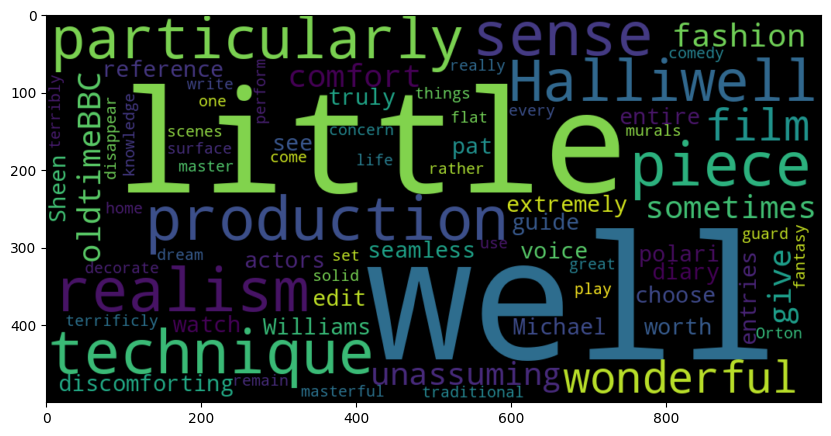

In [ ]:
#Note: Here, Word cloud represent words that contributes towards a particular sentiment. Higher weights given to more frequent words.
#Generate word cloud for positive review words
plt.figure(figsize=(10,10))
pos_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
pos_words=WC.generate(pos_text)
plt.imshow(pos_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

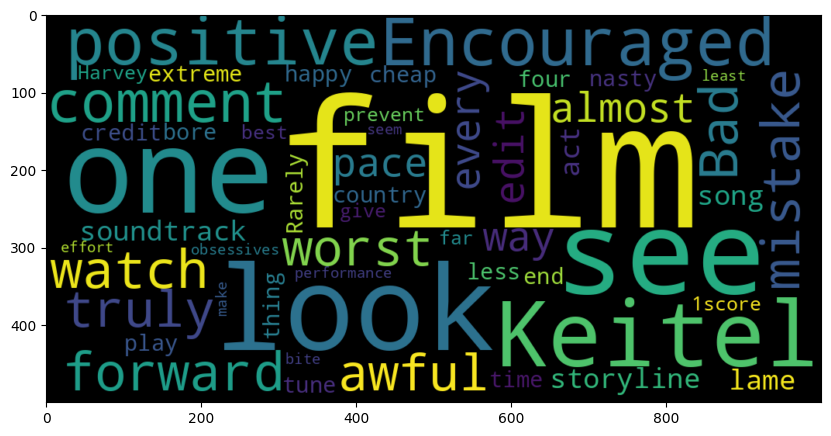

In [ ]:
#Generate word cloud for negative review words
plt.figure(figsize=(10,10))
neg_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
neg_words=WC.generate(neg_text)
plt.imshow(neg_words,interpolation='bilinear')
plt.show

# 6. Creating Bag of Words and Calculating TF-IDF
- Generate simple numeric BoW (Bag of Words) and TF-IDF (term frequency-inverse document frequency) features to train some baseline models.
- These features are mainly based on word frequencies and does not consider the context of a review.

In [ ]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#Transform train reviews into bag of words
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#Transform test reviews into bag of words
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6217572)
BOW_cv_test: (10000, 6217572)


In [ ]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#Transform train reviews into TF-IDF
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#Transform test reviews into TF-IDF
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6217572)
Tfidf_test: (10000, 6217572)


# 7. Training the Baseline Models (Naive Bayes and Logistic Regression Model)

Training a Multinomial Naive Bayes model using the BoW and TF-IDF features.

In [ ]:
#Create the Naive Bayes model
mnb=MultinomialNB()
#Fit the Naive Bayes for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments.ravel())
print(mnb_bow)
#Fit the Naive Bayes for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments.ravel())
print(mnb_tfidf)


MultinomialNB()
MultinomialNB()


Evaluating the Multinomial Naive Bayes model trained with BoW and TF-IDF.
- Both feature sets produced similar accuracy (~74%)

In [ ]:
#Prediction using the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Prediction using the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
mnb_bow_score : 0.7482
mnb_tfidf_score : 0.7483


Training a Logictic Regression model using the BoW and TF-IDF features.

In [ ]:
#Create the Logistic Regression model
lr_model = LogisticRegression()
#Fit the Logistic Regression for bag of words
lr_bow_model = lr_model.fit(cv_train_reviews,train_sentiments.ravel())
#Fit the Logistic Regression for tfidf features
lr_tfidf_model = lr_model.fit(tv_train_reviews,train_sentiments.ravel())

Evaluating the Logistic Regression model trained with BoW and TF-IDF.
- Both feature sets produced similar accuracy (~74%)

In [ ]:
#Prediction using the model for bag of words
lr_bow_predict=lr_model.predict(cv_test_reviews)
print(lr_bow_predict)
#Prediction using the model for tfidf features
lr_tfidf_predict=lr_model.predict(tv_test_reviews)
print(lr_tfidf_predict)

#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
lr_bow_score : 0.7478
lr_tfidf_score : 0.749


Remarks:
1. Both baseline models (Naive Bayes and Logistic Regression) produced similar accuracies (~74%-76%) with both set of features.
2. BoW and TF-IDF only considers frequency of occurances of words and not the context. Thus, next I explored word embeddings and machine learning model that capture sequential context information from text data to improve the classification accuracy. 

# 8. Improvement over the baseline model: BiLSTM Model with Word Embeddings
- Here, I construct a BiLSTM Model where the embedding layer is initialized with Pre-trained GloVe Embeddings (Alternative embeddings that are not explored in this notebook: Word2Vec or simply the embeddings generated during training). BiLSTM is used instead of LSTM, since looking both ways could help the model to understand the context better.
- The number of BiLSTM layers are decided based on Keras hyperparameter tuning.

In [ ]:
# define CONSTANTS
MAX_NB_WORDS = 20000 # maximum number of words present in IMDB reviews
MAX_SEQUENCE_LENGTH = 100 # maximum BiLSTM input sequence length
EMBEDDING_DIM = 100 # embedding dimension for tokens
VALIDATION_SPLIT = 0.2 # % of data to be used as validation set

# Define function to read pre trained embeddings from downloaded file
def fetch_embeddings(embedding_file):
  # Define dictionary to store embedding for different words
  embeddings_dict = {}
  # Open the embedding file
  f = open(embedding_file, encoding="utf8")
  # For each word, store the embedding in the dictionary
  for line in f:
      values = line.split()
      word = values[0]
      try:
          coefs = np.asarray(values[1:], dtype='float32')
      except:
          pass
      embeddings_dict[word] = coefs
  # Close the embedding file
  f.close()
  # Print the count of words for which an embedding was found
  print('Total %s word vectors.' % len(embeddings_dict))
  # Return the embedding dictionary
  return embeddings_dict

# Define a function to create embedding matric for the words found in training data
def get_embedding_matrix(word_index, pre_embeddings):
  # Declare the embedding matrix as np array (size = # of words in training data * embedding dimension)
  embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
  # For each word found in the training data, look up for an pre-trained embedding in the embedding dictionary 
  for word, i in word_index.items():
      embedding_vector = pre_embeddings.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          if len(embedding_matrix[i]) != len(embedding_vector):
              print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                    "into shape", str(len(embedding_vector)), " Please make sure your"
                                                              " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
              exit(1)
          embedding_matrix[i] = embedding_vector
  # Return the embedding matrix
  return embedding_matrix

def get_train_test_data(all_data, norm_train_reviews, norm_test_reviews):
  # Define tokenizer and fit on the training data
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
  tokenizer.fit_on_texts(all_data)

  # Get all sequences and create an index for each word
  all_sequences = tokenizer.texts_to_sequences(all_data)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))

  # Convert text to sequences of integers
  train_sequences = tokenizer.texts_to_sequences(norm_train_reviews)
  test_sequences = tokenizer.texts_to_sequences(norm_test_reviews)

  # Pad sequences to have same length
  train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
  test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

  # Return the word indices, train and test sequences
  return word_index, train_data, test_data

In [ ]:
def construct_model(hp, word_index=None, embedding_matrix=None):
  # Define BiLSTM model
  model = Sequential()
  # This If-Else block determines if pre-trained embeddings are used or not in the Embedding layer
  # In this project, I used GloVe pre-trained embeddings
  if word_index is None or embedding_matrix is None:
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
  else:
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
  # The following for loop adds an additional BiLSTM layers depending on the search results from Keras hyperparameter tuning
  for i in range(hp.Int('layers', 0, 1)):
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
  # The Bidirectional LSTM layer
  model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
  # The Dense Layer
  model.add(Dense(1, activation='sigmoid'))
  # Model compilation
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [ ]:
# Prepare data and embeddings---------------------------------------------------------------------------------------
# Read train and test data. Create indices for the words in the train/test sequences
word_index, train_data, test_data = get_train_test_data(imdb_data['review'], norm_train_reviews, norm_test_reviews)
# Fetch pretrained embeddings
# downloaded from: https://github.com/stanfordnlp/GloVe
pre_embeddings = fetch_embeddings("study_job_ML/fellowship_ai/glove.6B.100d.txt")
# Make the embedding matrix using the embedding_dict
embedding_matrix = get_embedding_matrix(word_index, pre_embeddings)
# Split train data into train and validation for hyperparameter tuning. Using a hardcoded 20% images for validation only for tuning. For the final 
# training phase a random 20% will be used
val_data = train_data[:8000]
train_set = train_data[8000:]
val_labels = train_sentiments[:8000]
train_labels = train_sentiments[8000:]
#-------------------------------------------------------------------------------------------------------------------

Found 176791 unique tokens.
Total 400001 word vectors.


## 8.1 Network Selection Using Keras Hyperparameter Tuning

In [ ]:
# Defining a Keras tuner to decide on hyperparameters
# In this case, I only used the tuner to determine the number of BiLSTM layers required for better performance
tuner = keras_tuner.BayesianOptimization(
    hypermodel=construct_model, # the function to construct the model
    objective="val_accuracy", 
    max_trials = 2,
    executions_per_trial=1,
    overwrite=True,
    directory="/content/gdrive/MyDrive/study_job_ML/fellowship_ai",
    project_name="IMDB_review_sentiment_classification",
)
# Print the tuner search space 
tuner.search_space_summary()
tuner.search(train_set, train_labels, epochs=2, validation_data=(val_data, val_labels))
# Print the tuner results
tuner.results_summary()

# Get the best model and print the model summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 2 Complete [00h 27m 29s]
val_accuracy: 0.8834999799728394

Best val_accuracy So Far: 0.8845000267028809
Total elapsed time: 00h 42m 20s
Results summary
Results in /content/gdrive/MyDrive/study_job_ML/fellowship_ai/IMDB_review_sentiment_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
layers: 0
Score: 0.8845000267028809

Trial 1 summary
Hyperparameters:
layers: 1
Score: 0.8834999799728394


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2,084,609
Trainable params: 2,084,609
Non-trainable params: 0
_________________________________________________________________


## 8.2 Training the Best Model

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(1)
print(str(best_hps))

In [ ]:
# Construct the best model with best hyperparameters (the best model required only one BiLSTM layer)
model = construct_model(best_hps[0], word_index, embedding_matrix)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          17679200  
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,763,809
Trainable params: 17,763,809
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the best model
# The model will monitor the validation loss minimization during training
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
# Store the training history
history = model.fit(train_data, train_sentiments, validation_split=VALIDATION_SPLIT, epochs=10, batch_size=64, callbacks=[earlystopping])
# Note: The output of this cell is deleted

## 8.3 Visualizing Training History and Testing the Model

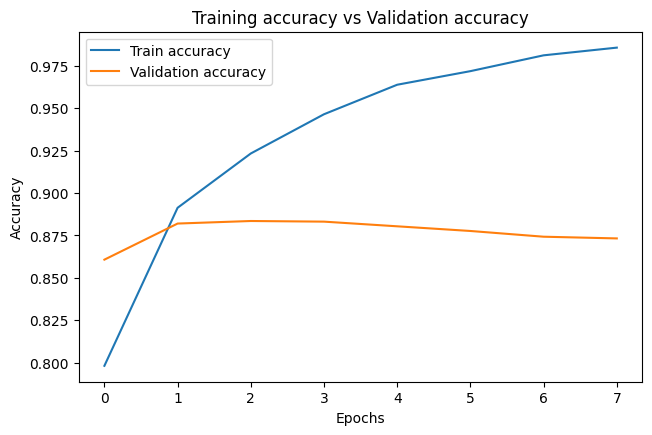

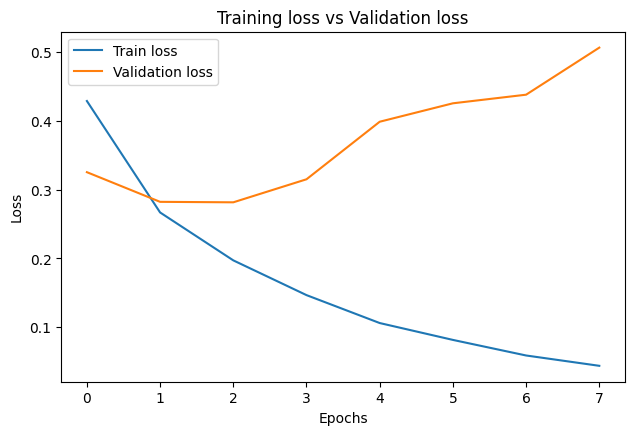

In [ ]:
# Define a function to plot the change in training and validation accuracy over the period of training
def plot_train_vs_validation_accuracy(history):
    fig = plt.figure(figsize=(16,10))

    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation accuracy")
    plt.title("Training accuracy vs Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

def plot_train_vs_validation_loss(history):
    fig = plt.figure(figsize=(16,10))

    plt.subplot(221)
    plt.plot(history.history['loss'], label = "Train loss")
    plt.plot(history.history['val_loss'], label = "Validation loss")
    plt.title("Training loss vs Validation loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()

plot_train_vs_validation_accuracy(history)
plot_train_vs_validation_loss(history)

# From the plot, it is evident that after the first 2/3 epochs validation loss/accuracy do not improve and overfitting occurs

In [ ]:
# Testing the model: Make prediction for the test data using the BiLSTM model trained with GloVe word embeddings
model_predictions=model.predict(test_data)
# Convert double value to binary
binary_predictions = np.round(model_predictions)
print(model_predictions.shape)

313/313 [==============================] - 34s 108ms/step
(10000, 1)


# 9. Evaluation
- Accuracy
- Overall Classification Report
- Confusion Matrix

In [ ]:
#Accuracy of the BiLSTM model on test data
model_score=accuracy_score(test_sentiments,binary_predictions)
print("BiLSTM_score :",model_score)
# Accuracy = 88.5%

BiLSTM_score : 0.885


In [ ]:
#Classification report for the BiLSTM model 
model_report=classification_report(test_sentiments,binary_predictions,target_names=['Positive','Negative'])
print(model_report)

# Based on this report, the model make correct predictions for both positive and negative sentiment labels somewhat equally

              precision    recall  f1-score   support

    Positive       0.88      0.89      0.89      4993
    Negative       0.89      0.88      0.88      5007

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.88     10000
weighted avg       0.89      0.89      0.88     10000



In [ ]:
#Confusion matrix for the BiLSTM model
cm_BiLSTM=confusion_matrix(test_sentiments,binary_predictions,labels=[1,0])
print(cm_BiLSTM)

[[4212  795]
 [ 448 4545]]


# End Remarks
- Incorporating contextual information using word embeddings and BiLSTM model achieved an improvement of around 12% over the baseline models that do not capture contextual information.
             BiLSTM model accuracy: ~88%
             Baseline model accuracy: ~74%
- I used Keras hyperparameter tuning to only select the network architecture. However, other hyperparameters like dropout rate, # of nodes in the BiLSTM layer, learning rate etc. could be also tuned in this phase. Due to resource and time constraints these hyperparameters are not tuned in this project.